In [ ]:
import sys

sys.path.append("../")

In [ ]:
import pandas as pd
import os

from scheduled.azure_client import download_data, upload_data

print(f"Time of execution: {pd.to_datetime('today').strftime('%Y-%m-%d %H:M:S')}")
# Download latest DCA-VMS data
# local_gp_data_path = '/home/knowit/Home_Foresee/data/data_cloud/vessel_data/'
local_gp_data_path = "/home/knowit/Home_Foresee/forseeModel/data/"
blob_gp_data_path = "VMS_DCA_joined/"
container_name = "fishlake"
download_data(blob_gp_data_path, local_gp_data_path, container_name)

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyproj
from global_land_mask import globe
import haversine as hs

In [ ]:
from pydap.client import open_url
from pydap.cas.get_cookies import setup_session
import xarray as xr
import numpy as np


# OPeNDAP connection
def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session

    cas_url = "https://cmems-cas.cls.fr/cas/login"
    session = setup_session(cas_url, username, password)
    try:
        session.cookies.set("CASTGC", session.cookies.get_dict()["CASTGC"])
    except:
        print("Bad credentials. Please try again.")
    database = ["my", "nrt"]
    url = f"https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}"
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
        print(database[0])
    except:
        url = f"https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}"
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
        print(database[1])
    return data_store

In [ ]:
ds = xr.open_dataset(datastore)
ds = ds.sel(time=slice("2011-01-01T12:00:00.000000000", None))
ds

<xarray.Dataset>
Dimensions:    (longitude: 4320, latitude: 2041, depth: 1, time: 21624)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth      (depth) float32 0.494
  * time       (time) datetime64[ns] 2020-11-01T00:30:00 ... 2023-04-20T23:30:00
Data variables:
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
Attributes:
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    title:        hourly mean fields from Global Ocean Physics Analysis and F...
    area:         Global
    Conventions:  CF-1.8
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    contact:      https://marine.copernicus.eu/contact
    references:   http://marine.copernicus.eu
    source:       MOI GLO12
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    institution:  Mercator Ocean International

In [ ]:
lon_bounds = -20.0, 45.0
lat_bounds = 50.0, 90.0

subset = ds.isel(depth=0).sel(longitude=slice(*lon_bounds), latitude=slice(*lat_bounds))

In [ ]:
ds_path = "/home/knowit/Home_Foresee/forseeModel/data/copernicus/nrt/copernicus-processed-data/CMEMS-GLOBAL_001_024-thetao-2020_2023.nc"
ds = xr.open_dataset(ds_path)
ds

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 397, time: 901, longitude: 1021)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 50.0 50.08 50.17 50.25 ... 82.83 82.92 83.0
  * time       (time) datetime64[ns] 2020-11-01T12:00:00 ... 2023-04-20T12:00:00
  * longitude  (longitude) float32 -35.0 -34.92 -34.83 ... 49.83 49.92 50.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes: (12/13)
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    title:             daily mean fields from Global Ocean Physics Analysis a...
    area:              Global
    Conventions:       CF-1.8
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    ...                ...
    source:            MOI GLO12
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    institution:       Mercator Ocean International
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    comment:           
    history:           Data extracted from dataset http://localhost:8080/thre...

In [ ]:
data = ds.isel(time=0)

x = data["x"].values
y = data["y"].values

X, Y = np.meshgrid(x, y)

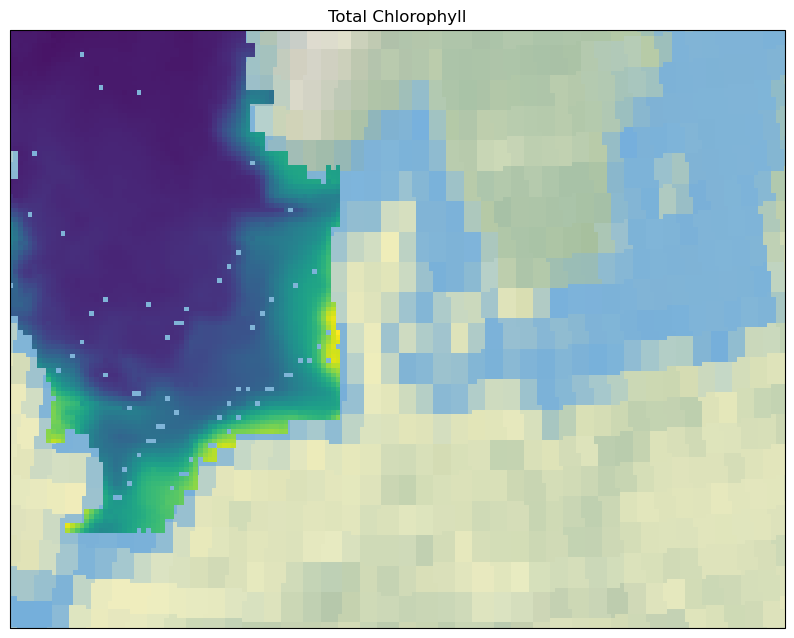

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.epsg("3035"))
ax.stock_img()
ax.pcolormesh(X, Y, data["chl"])
# ax.plot((-20, 45, 45, -20, -20), (50, 50, 90, 90, 50), color='r', linestyle='--', transform=ccrs.Geodetic())
# plt.imshow(m[::-1])
ax.set_extent([0, 20, 50, 60])
ax.set_title(data["chl"].long_name)
plt.show()

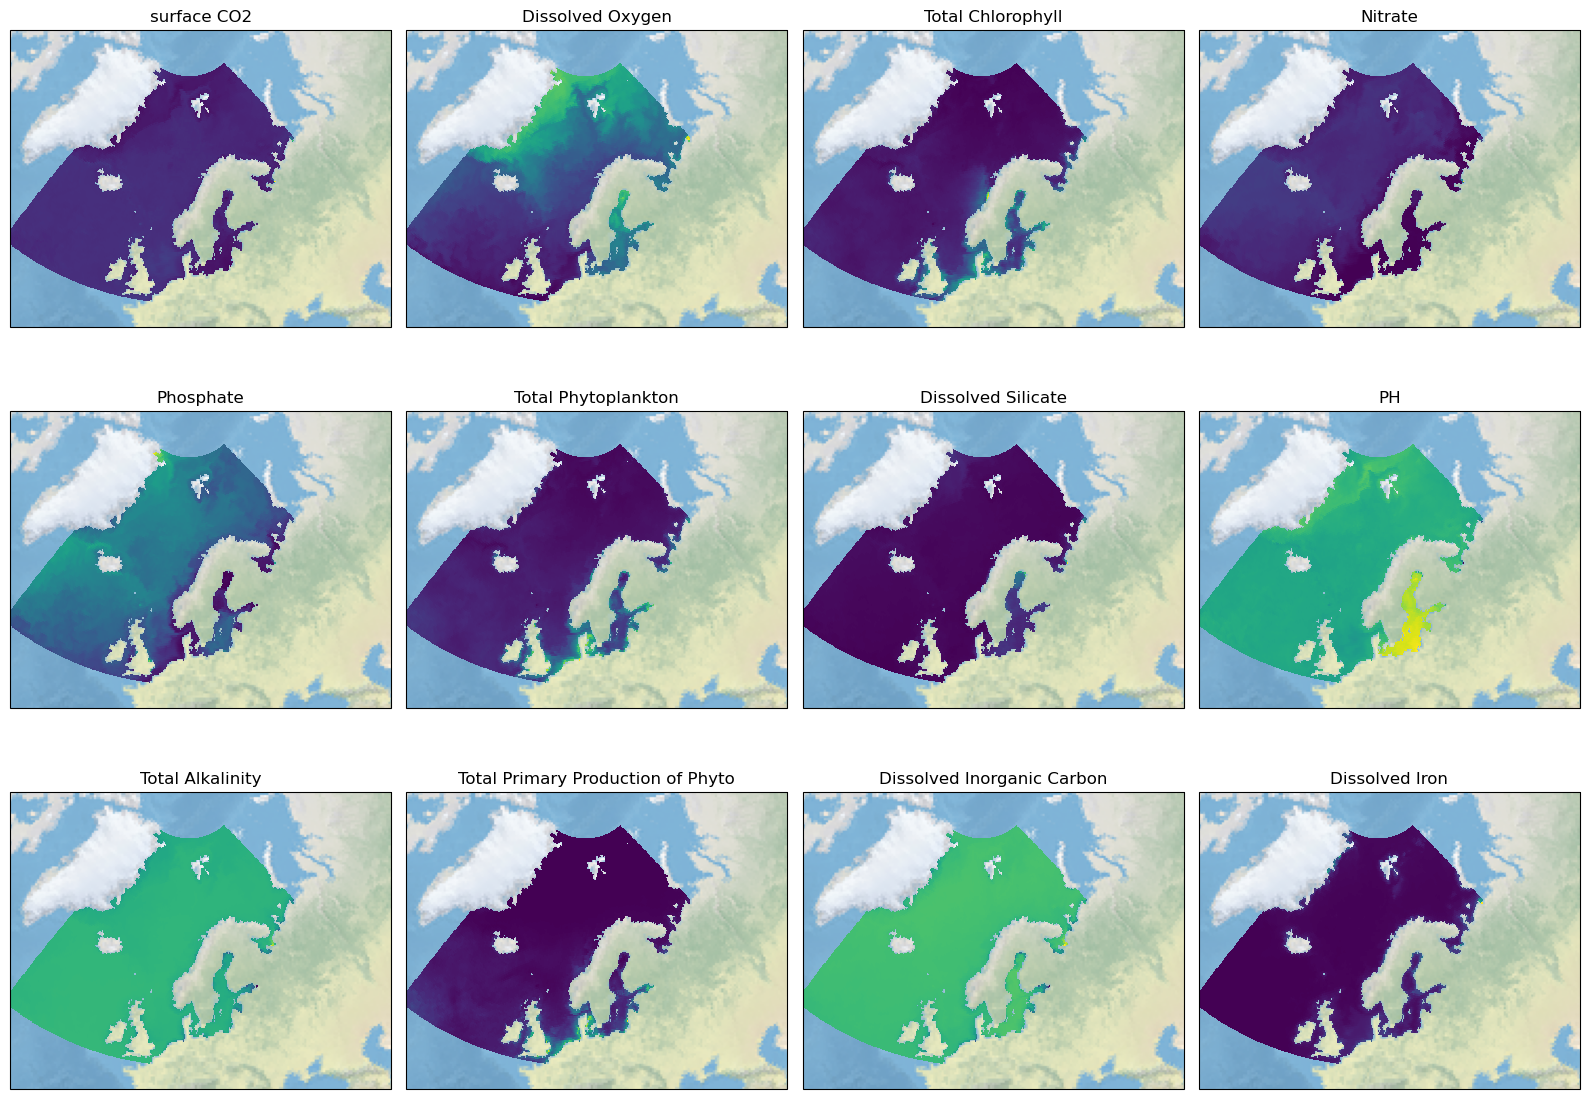

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(16, 12))
for i, k in enumerate(data.keys()):
    ax = plt.subplot(3, 4, i + 1, projection=ccrs.LambertAzimuthalEqualArea(10, 60))
    # ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(10, 60))
    ax.stock_img()
    ax.pcolormesh(lon_grid, lat_grid, data[k], transform=ccrs.PlateCarree())
    # ax.plot((-20, 45, 45, -20, -20), (50, 50, 90, 90, 50), color='r', linestyle='--', transform=ccrs.Geodetic())
    # plt.imshow(m[::-1])
    ax.set_extent([-25, 50, 40, 90])
    ax.set_title(data[k].long_name)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

pd.to_datetime(ds["time"].values[0]).strftime("%B")

'November'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation, PillowWriter


def animate_var(data, n, long_name=None):
    if long_name is None:
        long_name = data.long_name

    lons = data["longitude"].values
    lats = data["latitude"].values
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(10, 60))
    ax.stock_img()
    mesh = ax.pcolormesh(
        lon_grid, lat_grid, data.isel(time=0), transform=ccrs.PlateCarree()
    )
    ax.set_extent([-25, 50, 40, 90])
    # ax.set_extent([0, 20, 50, 60])
    ax.set_title(
        f"{long_name}, {pd.to_datetime(data['time'].values[0]).strftime('%B')}"
    )
    plt.tight_layout()

    def init():
        return (mesh,)

    def animate(i):
        print(i)
        mesh.set_array(data.isel(time=i).values.ravel())
        ax.set_title(
            f"{long_name}, {pd.to_datetime(data['time'].values[i]).strftime('%B')}"
        )
        return (mesh,)

    anim = FuncAnimation(
        fig, animate, init_func=init, frames=n, interval=500, blit=True
    )

    return anim


def animate_resampled_var(ds, var, n, long_name=None):
    data = ds[var]
    if long_name is None:
        long_name = data.long_name

    x = data["x"].values
    y = data["y"].values
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.epsg(ds.EPSG))
    ax.stock_img()
    mesh = ax.pcolormesh(X, Y, data.isel(time=0))
    ax.set_extent([-3, 10, 50, 64])
    ax.set_title(
        f"{long_name}, {pd.to_datetime(data['time'].values[0]).strftime('%B')}"
    )
    plt.tight_layout()

    def init():
        return (mesh,)

    def animate(i):
        print(i)
        mesh.set_array(data.isel(time=i).values.ravel())
        ax.set_title(
            f"{long_name}, {pd.to_datetime(data['time'].values[i]).strftime('%B')}"
        )
        return (mesh,)

    anim = FuncAnimation(
        fig, animate, init_func=init, frames=n, interval=500, blit=True
    )

    return anim

In [ ]:
import xarray as xr

ds = xr.open_dataset(
    "/home/knowit/Home_Foresee/forseeModel/data/copernicus/nrt/resampled/bio_north_sea.nc"
)
ds

<xarray.Dataset>
Dimensions:  (x: 52, y: 94, time: 895)
Coordinates:
  * x        (x) float64 3.575e+06 3.588e+06 3.6e+06 ... 4.197e+06 4.21e+06
  * y        (y) float64 4.361e+06 4.349e+06 4.336e+06 ... 3.23e+06 3.218e+06
  * time     (time) datetime64[ns] 2020-11-01T12:00:00 ... 2023-04-14T12:00:00
Data variables:
    spco2    (time, y, x) float64 ...
    o2       (time, y, x) float64 ...
    chl      (time, y, x) float64 ...
    no3      (time, y, x) float64 ...
    po4      (time, y, x) float64 ...
    phyc     (time, y, x) float64 ...
    si       (time, y, x) float64 ...
    ph       (time, y, x) float64 ...
    talk     (time, y, x) float64 ...
    nppv     (time, y, x) float64 ...
    dissic   (time, y, x) float64 ...
    fe       (time, y, x) float64 ...
Attributes:
    EPSG:     3035

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

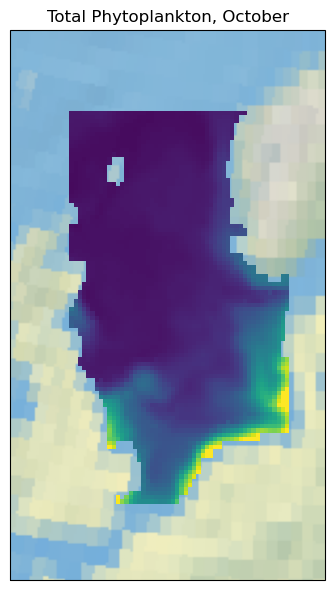

In [ ]:
anim = animate_resampled_var(ds, "phyc", 365)
# anim = animate_var(m, 365, 'Currents')

anim_path = "/home/knowit/Home_Foresee/forseeModel/animation/planktion.gif"
writergif = PillowWriter(fps=24)
anim.save(anim_path, writer=writergif)